In [3]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

In [4]:
n = 10000
a = torch.ones([n])
b = torch.ones([n])

In [5]:
class Timer: #@save
    '''记录多次运行时间'''
    def __init__(self):
        self.times = []
        self.start()
    def start(self):
        '''启动计时器'''
        self.tik = time.time()
    def stop(self):
        '''停止计时器并将时间记录在列表中'''
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    def avg(self):
        '''返回平均时间'''
        return sum(self.times) / len(self.times)
    def sum(self):
        '''返回时间总和'''
        return sum(self.times)
    def cumsum(self):
        '''返回累计时间'''
        return np.array(self.times).cumsum().tolist()

In [6]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.07131 sec'

In [7]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00030 sec'

In [8]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

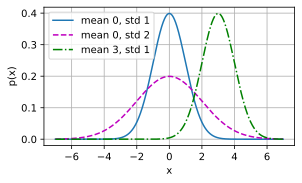

In [9]:
x = np.arange(-7, 7, 0.01)
# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
             ylabel='p(x)', figsize=(4.5, 2.5),
             legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

### 线性回归的从零开始实现

In [10]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

def synthetic_data(w, b, num_examples): #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [11]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [12]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([ 0.3278, -0.2551]) 
label: tensor([5.7150])


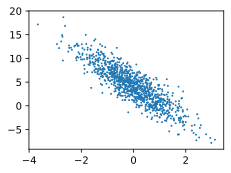

In [13]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

In [14]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]


In [15]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.0116, -0.2546],
        [ 1.8501, -0.1621],
        [-0.3661, -1.5346],
        [ 1.2525,  0.8234],
        [-0.4278, -0.8340],
        [ 0.5036, -0.1478],
        [ 1.4897,  1.4862],
        [-0.8233, -0.9735],
        [-0.8032, -0.1394],
        [ 0.0349,  1.1701]]) 
 tensor([[5.0726],
        [8.4617],
        [8.6919],
        [3.8995],
        [6.1905],
        [5.6974],
        [2.1285],
        [5.8626],
        [3.0749],
        [0.3122]])


#### 初始化模型参数

In [16]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [17]:
print(w)
print(b)

tensor([[-0.0055],
        [-0.0137]], requires_grad=True)
tensor([0.], requires_grad=True)


#### 定义模型

In [18]:
def linreg(X, w, b): #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

#### 定义损失函数

In [19]:
def squared_loss(y_hat, y): #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

#### 定义优化算法

In [20]:
def sgd(params, lr, batch_size): #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [21]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [22]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.033887
epoch 2, loss 0.000126
epoch 3, loss 0.000051


In [23]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 1.0490e-05, -9.8491e-04], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0001], grad_fn=<RsubBackward1>)


In [24]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

# 读取数据集
'''
我们可以调用框架中现有的API来读取数据。我们将features和labels作为API的参数传递，并通过数据迭代器指定batch_size。
此外，布尔值is_train表示是否希望数据迭代器对象在每个迭代周期内打乱数据。
'''
def load_array(data_arrays, batch_size, is_train=True): #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)
batch_size = 10
data_iter = load_array((features, labels), batch_size)

'''
为了验证是否正常工作，让我们读取并打印第一个小批量样本。与前面不同，这里我们使用iter构造Python迭代器，并使用next从迭代器中
获取第一项。
'''
next(iter(data_iter))

# 定义模型
# nn是神经网络的缩写
from torch import nn
net = nn.Sequential(nn.Linear(2, 1))

# 初始化模型参数
'''
在使用net之前，我们需要初始化模型参数。如在线性回归模型中的权重和偏置。深度学习框架通常有预定义的方法来初始化参数。
在这里，我们指定每个权重参数应该从均值为0、标准差为0.01的正态分布中随机采样，偏置参数将初始化为零。

正如我们在构造nn.Linear时指定输入和输出尺寸一样，现在我们能直接访问参数以设定它们的初始值。我们通过net[0]选择网络中
的第一个图层，然后使用weight.data和bias.data方法访问参数。我们还可以使用替换方法normal_和fill_来重写参数值。
'''
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

# 定义损失函数
# 计算均方误差使用的是MSELoss类，也称为平方L2范数。默认情况下，它返回所有样本损失的平均值。
loss = nn.MSELoss()

# 定义优化算法
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

'''
小批量随机梯度下降算法是一种优化神经网络的标准工具，PyTorch在optim模块中实现了该算法的许多变种。当我们实例化一个
SGD实例时，我们要指定优化的参数（可通过net.parameters()从我们的模型中获得）以及优化算法所需的超参数字典。小批量随
机梯度下降只需要设置lr值，这里设置为0.03。
'''
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

# 训练
'''
通过深度学习框架的高级API来实现我们的模型只需要相对较少的代码。我们不必单独分配参数、不必定义我们的损失函数，也不必
手动实现小批量随机梯度下降。当我们需要更复杂的模型时，高级API的优势将大大增加。当我们有了所有的基本组件，训练过程代
码与我们从零开始实现时所做的非常相似。
'''
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

# 比较生成数据集的真实参数和通过有限数据训练获得的模型参数。
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

epoch 1, loss 0.000246
epoch 2, loss 0.000104
epoch 3, loss 0.000103
w的估计误差： tensor([-0.0002, -0.0008])
b的估计误差： tensor([0.0002])


### 图像分类数据集

In [25]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
d2l.use_svg_display()

In [26]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0～1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

In [27]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [28]:
mnist_train[0][0].shape
mnist_test[0][0].shape

torch.Size([1, 28, 28])

In [29]:
def get_fashion_mnist_labels(labels): #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [30]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

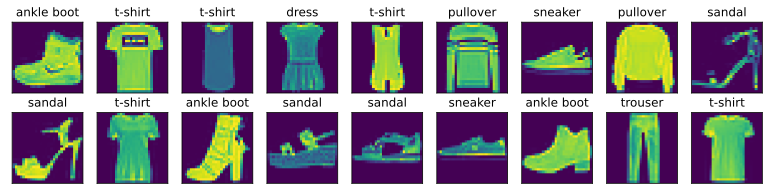

In [31]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

In [32]:
batch_size = 256
def get_dataloader_workers(): #@save
    """使用4个进程来读取数据"""
    return 4
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())

In [33]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'1.15 sec'

In [34]:
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [35]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


### softmax回归的从零开始实现

In [36]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [37]:
num_inputs = 784
num_outputs = 10
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [38]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [39]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition # 这里应用了广播机制

X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.1195, 0.2224, 0.1892, 0.0596, 0.4092],
         [0.2683, 0.2779, 0.2659, 0.1061, 0.0818]]),
 tensor([1.0000, 1.0000]))

In [40]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [41]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [42]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])
cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [43]:
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [44]:
accuracy(y_hat, y) / len(y)

0.5

In [45]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [46]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [47]:
evaluate_accuracy(net, test_iter)

0.035

In [48]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [49]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[].__iter__() for _ in range(n)]
            # 原代码为 self.X = [[], for _ in range(n)]，这里修正为正确的列表推导式写法
            self.X = [[], ] * n  
        if not self.Y:
            self.Y = [[].__iter__() for _ in range(n)]
            self.Y = [[], ] * n  
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [50]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

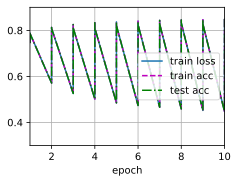

In [51]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)


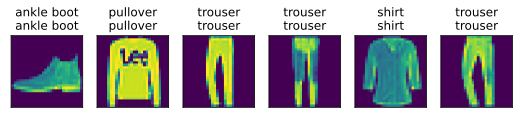

In [52]:
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

In [53]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

### softmax回归的简洁实现

In [54]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [55]:
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

In [56]:
loss = nn.CrossEntropyLoss(reduction='none')

In [57]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

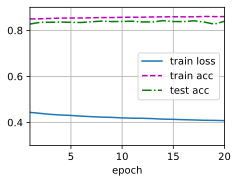

In [59]:
num_epochs = 20
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)